In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Import Libraries


In [ ]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.util import ngrams

import re
import string
from collections import Counter, defaultdict

from textblob import TextBlob
from wordcloud import WordCloud, STOPWORDS

# Import Dataset


In [ ]:
data_path = "/content/drive/MyDrive/DS532 Text/project"
df = pd.read_json(f"{data_path}/reviews_Grocery_and_Gourmet_Food.json", lines=True, nrows=10000)

In [ ]:
# data preview
df.head()

,reviewerID,asin,reviewerName,helpful,reviewText,overall,summary,unixReviewTime,reviewTime
0,A1ZQZ8RJS1XVTX,0657745316,gsxrgirl,"[0, 0]","No sugar, no GMO garbage, no fillers that come...",5,Best vanilla I've ever had,1381449600,"10 11, 2013"
1,A31W38VGZAUUM4,0700026444,FIFA Lvr,"[1, 1]","This is my absolute, undisputed favorite tea r...",5,Terrific Tea!,1354752000,"12 6, 2012"
2,A3I0AV0UJX5OH0,1403796890,Alicia b,"[0, 0]",I ordered spongbob slippers and I got John Cen...,1,grrrrrrr,1385942400,"12 2, 2013"
3,A3QAAOLIXKV383,1403796890,"Danny K. Tilley ""Dan Tilley""","[0, 0]",The cart is fine and works for the purpose for...,3,Storage on Wheels Cart,1307836800,"06 12, 2011"
4,AB1A5EGHHVA9M,141278509X,CHelmic,"[1, 1]",This product by Archer Farms is the best drink...,5,The best drink mix,1332547200,"03 24, 2012"


# Data Description

In [ ]:
# print dataset information
print (df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   reviewerID      10000 non-null  object
 1   asin            10000 non-null  object
 2   reviewerName    9975 non-null   object
 3   helpful         10000 non-null  object
 4   reviewText      10000 non-null  object
 5   overall         10000 non-null  int64 
 6   summary         10000 non-null  object
 7   unixReviewTime  10000 non-null  int64 
 8   reviewTime      10000 non-null  object
dtypes: int64(2), object(7)
memory usage: 703.2+ KB
None


This dataset pertains to reviews of Grocery and Gourmet food products on Amazon, comprising 9 columns of raw data with the following descriptions:

1. **reviewerID**: The unique identifier of the reviewer.
2. **asin**: The Amazon Standard Identification Number (ASIN) of the product.
3. **reviewerName**: The name of the reviewer.
4. **helpful**: The helpfulness rating of the review.
5. **reviewText**: The text content of the review.
6. **overall**: The overall rating given to the product.
7. **summary**: A brief summary of the review.
8. **unixReviewTime**: The time of the review in Unix format.
9. **reviewTime**: The time of the review.





# Data Cleaning and Pre-processing

## Handling with Null Values

In [ ]:
#Checking for null values
print('The null values in the dataset:')
df.isnull().sum()

The null values in the dataset:


reviewerID         0
asin               0
reviewerName      25
helpful            0
reviewText         0
overall            0
summary            0
unixReviewTime     0
reviewTime         0
dtype: int64

The null values are in the unneccessary column so i will remove the column in the next step

## Renaming and Removing unnecessary features

In [ ]:
# Rename columns making it easy to interpret
df.rename(columns={'overall': 'rating'}, inplace=True)

In [ ]:
#Removing unnecessary columns
df = df.drop(['reviewerName','unixReviewTime'], axis=1)

## Combining reviewText and summary
both of these columns are the same

In [ ]:
df['reviews'] = df['reviewText'] + df['summary']
df = df.drop(['reviewText', 'summary'], axis=1)

df.head()

,reviewerID,asin,helpful,rating,reviewTime,reviews
0,A1ZQZ8RJS1XVTX,0657745316,"[0, 0]",5,"10 11, 2013","No sugar, no GMO garbage, no fillers that come..."
1,A31W38VGZAUUM4,0700026444,"[1, 1]",5,"12 6, 2012","This is my absolute, undisputed favorite tea r..."
2,A3I0AV0UJX5OH0,1403796890,"[0, 0]",1,"12 2, 2013",I ordered spongbob slippers and I got John Cen...
3,A3QAAOLIXKV383,1403796890,"[0, 0]",3,"06 12, 2011",The cart is fine and works for the purpose for...
4,AB1A5EGHHVA9M,141278509X,"[1, 1]",5,"03 24, 2012",This product by Archer Farms is the best drink...


## Adding the new "sentiment" feature

In [ ]:
print('The distribution of categories of sentiment:')
df['rating'].value_counts()

The distribution of categories of sentiment:


5    6761
4    1293
1     860
3     662
2     424
Name: rating, dtype: int64

In [ ]:
def sent(rating):
    if rating == 2:
        value = 'Somewhat Negative'
    elif rating == 3:
        value = 'Neutral'
    elif rating == 4:
        value = 'Somewhat Positive'
    elif rating == 5:
        value = 'Very Positive'
    else:
        value = 'Very Negative'
    return value

In [ ]:
# Applying the function to create a new column 'sentiment'
df['sentiment'] = df.apply(lambda row: sent(row['rating']), axis=1)

df.head()

,reviewerID,asin,helpful,rating,reviewTime,reviews,sentiment
0,A1ZQZ8RJS1XVTX,0657745316,"[0, 0]",5,"10 11, 2013","No sugar, no GMO garbage, no fillers that come...",Very Positive
1,A31W38VGZAUUM4,0700026444,"[1, 1]",5,"12 6, 2012","This is my absolute, undisputed favorite tea r...",Very Positive
2,A3I0AV0UJX5OH0,1403796890,"[0, 0]",1,"12 2, 2013",I ordered spongbob slippers and I got John Cen...,Very Negative
3,A3QAAOLIXKV383,1403796890,"[0, 0]",3,"06 12, 2011",The cart is fine and works for the purpose for...,Neutral
4,AB1A5EGHHVA9M,141278509X,"[1, 1]",5,"03 24, 2012",This product by Archer Farms is the best drink...,Very Positive


In [ ]:
print('The count of sentiments:')
df['sentiment'].value_counts()

The count of sentiments:


Very Positive        6761
Somewhat Positive    1293
Very Negative         860
Neutral               662
Somewhat Negative     424
Name: sentiment, dtype: int64

## Handling with Time

In [ ]:
# Convert 'reviewTime' to normal date-time format
df['reviewTime'] = pd.to_datetime(df['reviewTime'])

In [ ]:
# Separate Year, Month, and Day into columns
df['year'] = df['reviewTime'].dt.year
df['month'] = df['reviewTime'].dt.month
df['day'] = df['reviewTime'].dt.day

# drop the original datetime column
df = df.drop(['reviewTime'], axis=1)
df.head()

,reviewerID,asin,helpful,rating,reviews,sentiment,year,month,day
0,A1ZQZ8RJS1XVTX,0657745316,"[0, 0]",5,"No sugar, no GMO garbage, no fillers that come...",Very Positive,2013,10,11
1,A31W38VGZAUUM4,0700026444,"[1, 1]",5,"This is my absolute, undisputed favorite tea r...",Very Positive,2012,12,6
2,A3I0AV0UJX5OH0,1403796890,"[0, 0]",1,I ordered spongbob slippers and I got John Cen...,Very Negative,2013,12,2
3,A3QAAOLIXKV383,1403796890,"[0, 0]",3,The cart is fine and works for the purpose for...,Neutral,2011,6,12
4,AB1A5EGHHVA9M,141278509X,"[1, 1]",5,This product by Archer Farms is the best drink...,Very Positive,2012,3,24


### Preview analysis : Grouping sentiment by Year

In [ ]:
# To preview with basis analytic with year-wise count of sentiment
sentiment_counts = df.groupby(['year', 'sentiment']).size()
print(sentiment_counts)

year  sentiment        
2000  Somewhat Positive       1
      Very Positive           2
2001  Very Positive           1
2002  Neutral                 2
      Very Negative           1
                           ... 
2014  Neutral               134
      Somewhat Negative      79
      Somewhat Positive     222
      Very Negative         162
      Very Positive        1325
Length: 66, dtype: int64


## Handling with "helpful" feature

In [ ]:
# Convert 'helpful' column to string type
df['helpful'] = df['helpful'].astype(str)

# Split 'helpful' column to extract helpful votes and total votes
split_helpful = df['helpful'].str.split(",", n=1, expand=True)
helpful_votes = split_helpful[0].str.split("[", n=1, expand=True)[1].astype(int)
total_votes = split_helpful[1].str.split("]", n=1, expand=True)[0].astype(int)

# Calculate helpfulness ratio, handling zero division explicitly
# Checking for zero values before division
helpfulness_ratio = total_votes / helpful_votes
helpfulness_ratio[helpful_votes == 0] = 0  # Assigning 0 to cases where helpful votes are zero

# Fill NaN values with 0
helpfulness_ratio = helpfulness_ratio.fillna(0)

# Round the helpfulness ratio to two decimal places
helpfulness_ratio = helpfulness_ratio.round(2)

# Attach helpfulness ratio to a new column in the main DataFrame
df['helpful_review'] = helpfulness_ratio

# Drop the original 'helpful' column from the main DataFrame
df = df.drop(['helpful'], axis=1)

df.head()

,reviewerID,asin,rating,reviews,sentiment,year,month,day,helpful_review
0,A1ZQZ8RJS1XVTX,0657745316,5,"No sugar, no GMO garbage, no fillers that come...",Very Positive,2013,10,11,0.0
1,A31W38VGZAUUM4,0700026444,5,"This is my absolute, undisputed favorite tea r...",Very Positive,2012,12,6,1.0
2,A3I0AV0UJX5OH0,1403796890,1,I ordered spongbob slippers and I got John Cen...,Very Negative,2013,12,2,0.0
3,A3QAAOLIXKV383,1403796890,3,The cart is fine and works for the purpose for...,Neutral,2011,6,12,0.0
4,AB1A5EGHHVA9M,141278509X,5,This product by Archer Farms is the best drink...,Very Positive,2012,3,24,1.0


In [ ]:
df['helpful_review'].value_counts()

0.00     5717
1.00     2754
2.00      371
1.50      196
1.33      121
         ... 
1.35        1
4.80        1
3.75        1
1.52        1
10.00       1
Name: helpful_review, Length: 110, dtype: int64

## Removing Stop words

In [ ]:
# Download stopwords
nltk.download('stopwords')

# Define a function to remove stop words
def remove_stopwords(text):
    stop_words = set(stopwords.words('english'))
    words = text.split()
    filtered_words = [word for word in words if word.lower() not in stop_words]
    return ' '.join(filtered_words)

# Apply the stop words removal function to the 'reviews' column
df['reviews'] = df['reviews'].apply(remove_stopwords)

df.head()

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


,reviewerID,asin,rating,reviews,sentiment,year,month,day,helpful_review
0,A1ZQZ8RJS1XVTX,0657745316,5,"sugar, GMO garbage, fillers come store bought ...",Very Positive,2013,10,11,0.0
1,A31W38VGZAUUM4,0700026444,5,"absolute, undisputed favorite tea right now. l...",Very Positive,2012,12,6,1.0
2,A3I0AV0UJX5OH0,1403796890,1,ordered spongbob slippers got John Cena happy ...,Very Negative,2013,12,2,0.0
3,A3QAAOLIXKV383,1403796890,3,cart fine works purpose bought it. (Farmers's ...,Neutral,2011,6,12,0.0
4,AB1A5EGHHVA9M,141278509X,5,product Archer Farms best drink mix ever. mix ...,Very Positive,2012,3,24,1.0


## Removing Punctuation

In [ ]:
# Define a function to remove all punctuation patterns
def clean_review(text):
    text = str(text).lower()
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'https?://\S+|www\.\S+', '', text)  # Remove links
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'[%s]' % re.escape(string.punctuation), '', text)  # Remove punctuation
    text = re.sub(r'\n', '', text)  # Remove newline characters
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    return text

# Apply the cleaning function to the 'reviews' column
df['reviews'] = df['reviews'].apply(clean_review)

df.head()

,reviewerID,asin,rating,reviews,sentiment,year,month,day,helpful_review
0,A1ZQZ8RJS1XVTX,0657745316,5,sugar gmo garbage fillers come store bought ex...,Very Positive,2013,10,11,0.0
1,A31W38VGZAUUM4,0700026444,5,absolute undisputed favorite tea right now lov...,Very Positive,2012,12,6,1.0
2,A3I0AV0UJX5OH0,1403796890,1,ordered spongbob slippers got john cena happy ...,Very Negative,2013,12,2,0.0
3,A3QAAOLIXKV383,1403796890,3,cart fine works purpose bought it farmerss mar...,Neutral,2011,6,12,0.0
4,AB1A5EGHHVA9M,141278509X,5,product archer farms best drink mix ever mix f...,Very Positive,2012,3,24,1.0


## Export to CSV

In [ ]:
# the file path in Google Drive
path = "/content/drive/MyDrive/DS532 Text/project/sentiment_for_analysis.csv"

# Save the DataFrame to CSV
df.to_csv(path, index=False)

print(f"File saved to {path} successfully.")

File saved to /content/drive/MyDrive/DS532 Text/project/sentiment_for_analysis.csv successfully.


# Exploratory data analysis (EDA)

## Rating and Sentiment Exploration

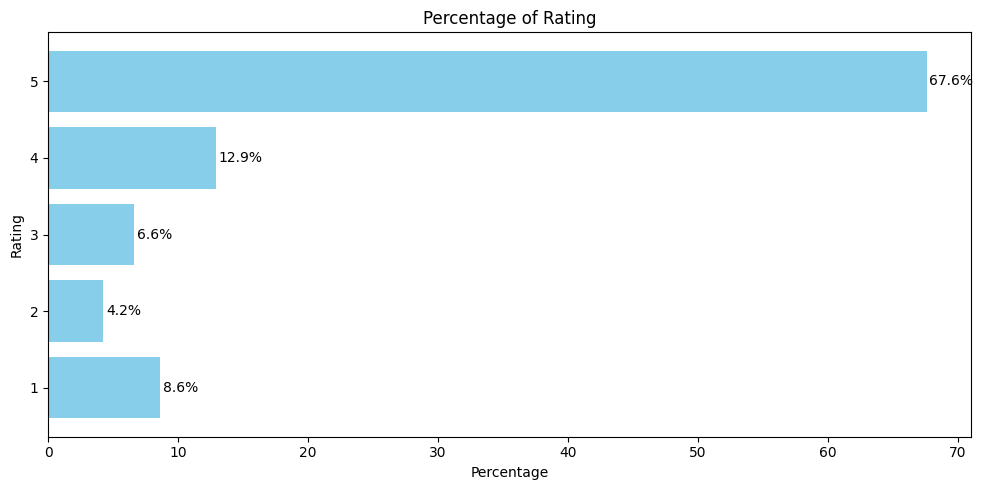

In [ ]:
# Calculate percentages of each rating
rating_counts = df['rating'].value_counts(normalize=True) * 100

# Set up the figure
plt.figure(figsize=(10, 5))
plt.title('Percentage of Rating')

# Create the countplot
bars = plt.barh(rating_counts.index, rating_counts.values, color='skyblue')

# Add percentages to the bars
for bar in bars:
    plt.text(bar.get_width() + 0.2, bar.get_y() + bar.get_height()/2, f'{bar.get_width():.1f}%',
             va='center', ha='left')

# Set labels and show plot
plt.xlabel('Percentage')
plt.ylabel('Rating')

plt.tight_layout()
plt.show()

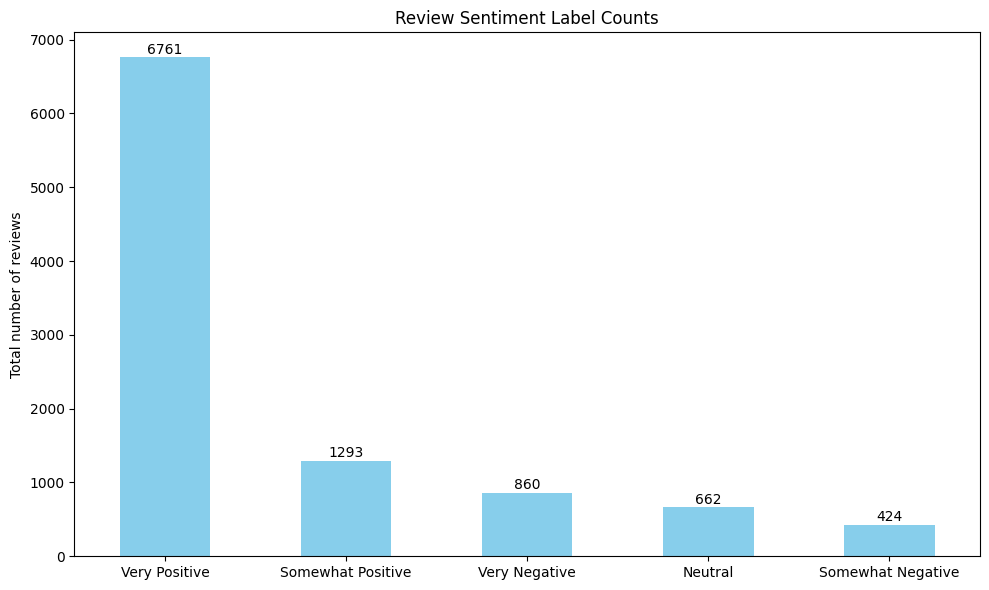

In [ ]:
# Count the number of reviews for each sentiment label
sentiment_counts = df["sentiment"].value_counts()

# Plot the counts of each sentiment label as a bar plot
plt.figure(figsize=(10, 6))
sentiment_counts.plot(kind="bar", color='skyblue')
plt.title("Review Sentiment Label Counts")
plt.ylabel("Total number of reviews")
plt.xticks(rotation=0)

# Add annotations to the bars
for i, count in enumerate(sentiment_counts):
    plt.text(i, count + 50, str(count), ha='center')

plt.tight_layout()
plt.show()

## Year-wise sentiment

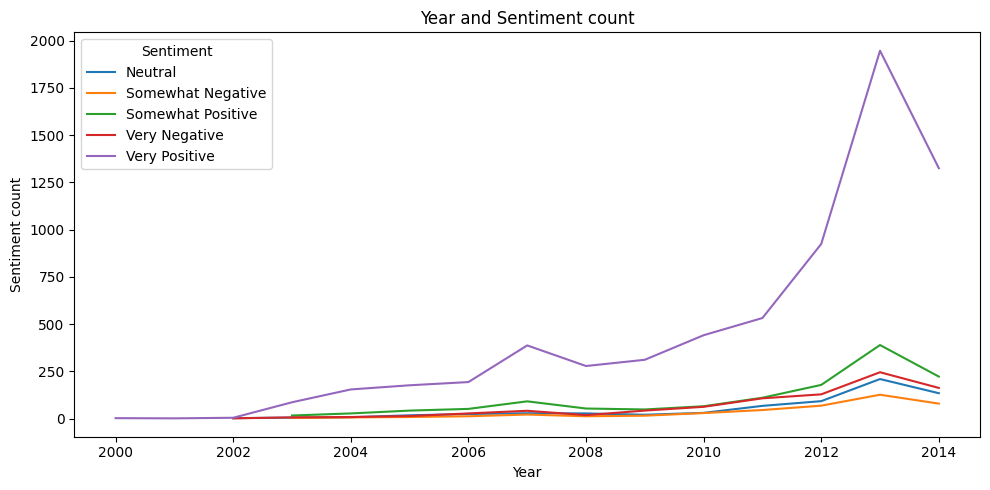

In [ ]:
# Group by year and sentiment, and count occurrences
sentiment_counts = df.groupby(['year', 'sentiment'])['sentiment'].count().unstack()

# Plot the grouped data
ax = sentiment_counts.plot(kind='line', figsize=(10, 5))

# Set titles and labels
plt.title('Year and Sentiment count')
plt.xlabel('Year')
plt.ylabel('Sentiment count')

# Display the legend
plt.legend(title='Sentiment')

# Show the plot
plt.tight_layout()
plt.show()

## Sentiment Distribution

In [ ]:
# Calculate polarity
df['polarity'] = df['reviews'].map(lambda text: TextBlob(text).sentiment.polarity)

# Calculate review length
df['review_len'] = df['reviews'].astype(str).apply(len)

# Calculate word count
df['word_count'] = df['reviews'].apply(lambda x: len(str(x).split()))

df.head()

,reviewerID,asin,rating,reviews,sentiment,year,month,day,helpful_review,polarity,review_len,word_count
0,A1ZQZ8RJS1XVTX,0657745316,5,sugar gmo garbage fillers come store bought ex...,Very Positive,2013,10,11,0.0,0.061508,341,50
1,A31W38VGZAUUM4,0700026444,5,absolute undisputed favorite tea right now lov...,Very Positive,2012,12,6,1.0,0.250000,432,64
2,A3I0AV0UJX5OH0,1403796890,1,ordered spongbob slippers got john cena happy ...,Very Negative,2013,12,2,0.0,0.200000,137,20
3,A3QAAOLIXKV383,1403796890,3,cart fine works purpose bought it farmerss mar...,Neutral,2011,6,12,0.0,0.058333,186,30
4,AB1A5EGHHVA9M,141278509X,5,product archer farms best drink mix ever mix f...,Very Positive,2012,3,24,1.0,0.487755,287,43


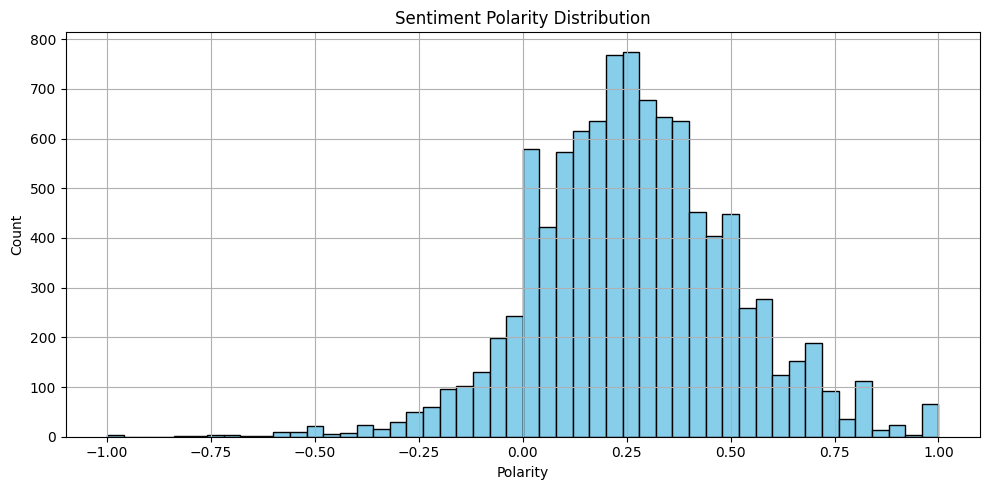

In [ ]:
# Create a histogram of sentiment polarity
plt.figure(figsize=(10, 5))
plt.hist(df['polarity'], bins=50, color='skyblue', edgecolor='black')
plt.xlabel('Polarity')
plt.ylabel('Count')
plt.title('Sentiment Polarity Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

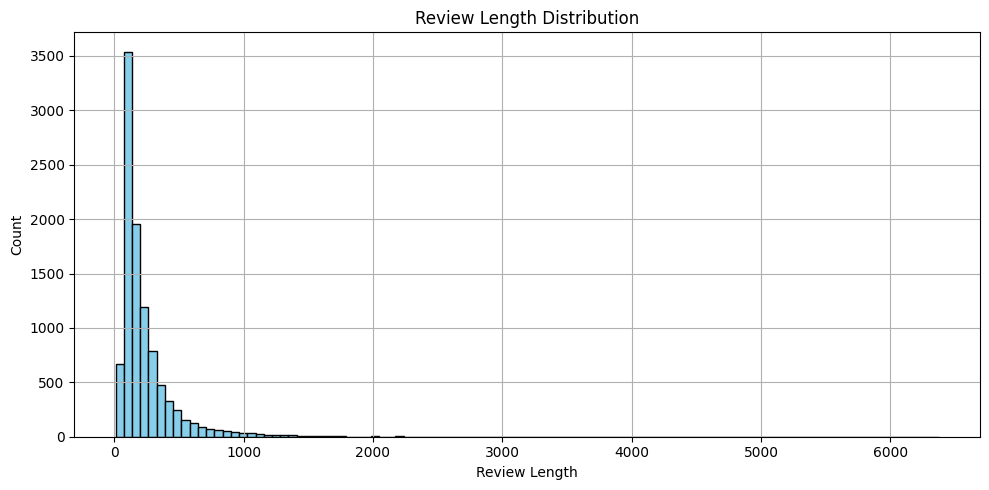

In [ ]:
# Create a histogram using Matplotlib
plt.figure(figsize=(10, 5))
plt.hist(df['review_len'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Review Length')
plt.ylabel('Count')
plt.title('Review Length Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

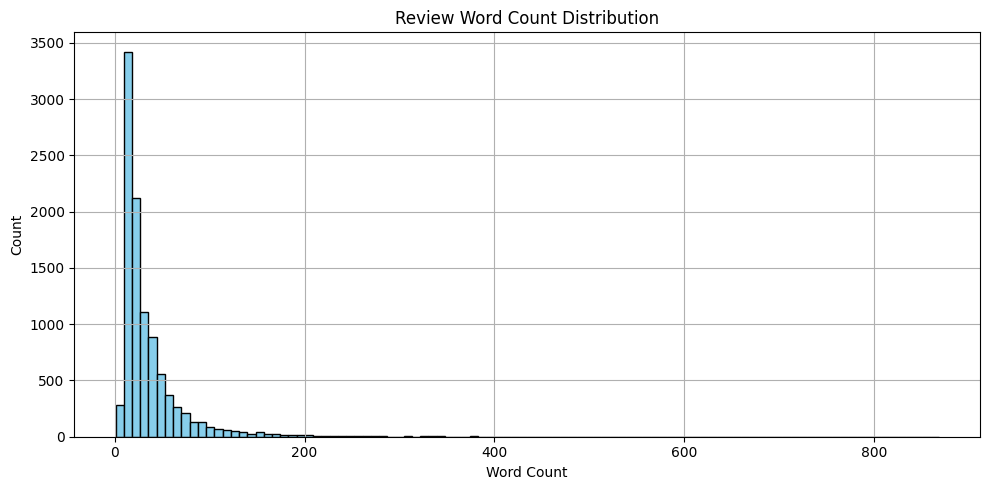

In [ ]:
# Create a histogram using Matplotlib
plt.figure(figsize=(10, 5))
plt.hist(df['word_count'], bins=100, color='skyblue', edgecolor='black')
plt.xlabel('Word Count')
plt.ylabel('Count')
plt.title('Review Word Count Distribution')
plt.grid(True)

plt.tight_layout()
plt.show()

## Most reviewed products (asin)


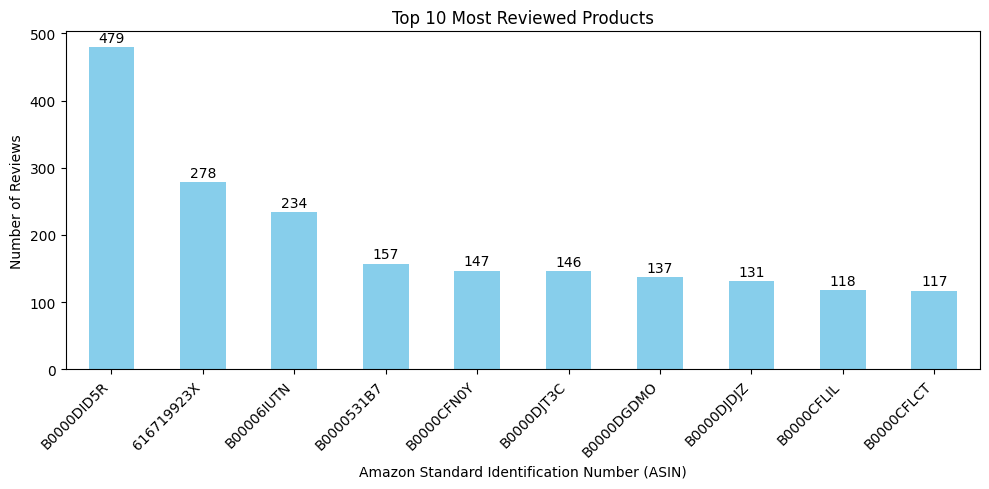

In [ ]:
# Group by 'asin' and count the number of reviews
product_reviews_count = df.groupby('asin').size().sort_values(ascending=False)

# Plotting the graph for the top 10 most reviewed products
plt.figure(figsize=(10, 5))
product_reviews_count[:10].plot(kind='bar', color='skyblue')
plt.xlabel('Amazon Standard Identification Number (ASIN)')
plt.ylabel('Number of Reviews')
plt.title('Top 10 Most Reviewed Products')
plt.xticks(rotation=45, ha='right')  # Rotate x-axis labels for better readability

# Add annotations to the bars
for i, count in enumerate(product_reviews_count[:10]):
    plt.text(i, count + 8, str(count), ha='center')

plt.tight_layout()
plt.show()

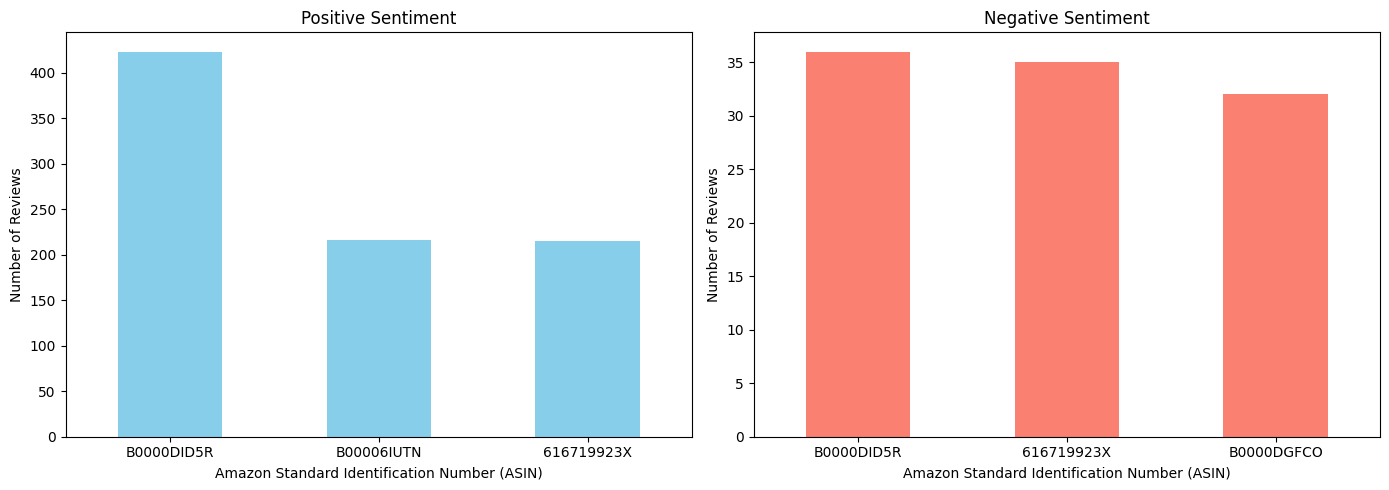

In [ ]:
# Filter the DataFrame to include only reviews with sentiment 'Very Positive' or 'Somewhat Positive'
positive_reviews = df[df['sentiment'].isin(['Very Positive', 'Somewhat Positive'])]
# Filter the DataFrame to include only reviews with sentiment 'Very Negative' or 'Somewhat Negative'
negative_reviews = df[df['sentiment'].isin(['Very Negative', 'Somewhat Negative'])]

# Group by 'asin' and count the number of positive and negative reviews separately
product_positive_reviews_count = positive_reviews.groupby('asin').size().sort_values(ascending=False)
product_negative_reviews_count = negative_reviews.groupby('asin').size().sort_values(ascending=False)

# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Plot positive sentiment
product_positive_reviews_count[:3].plot(kind='bar', color='skyblue', ax=axes[0])
axes[0].set_title('Positive Sentiment')
axes[0].set_xlabel('Amazon Standard Identification Number (ASIN)')
axes[0].set_ylabel('Number of Reviews')
axes[0].tick_params(axis='x', rotation=0)

# Plot negative sentiment
product_negative_reviews_count[:3].plot(kind='bar', color='salmon', ax=axes[1])
axes[1].set_title('Negative Sentiment')
axes[1].set_xlabel('Amazon Standard Identification Number (ASIN)')
axes[1].set_ylabel('Number of Reviews')
axes[1].tick_params(axis='x', rotation=0)

# Adjust layout
plt.tight_layout()
plt.show()

### Deep drive to top 3 most reviewed product with Word cloud

In [ ]:
# Filter the rows where 'asin' column equals "B0000DID5R"
filtered_rows = df[df['asin'] == "B0000DID5R"]
# Show the values of the 'reviews' column from the filtered rows
review_data_1st = filtered_rows['reviews']

print(review_data_1st)

7088    stuff peel paint hottest thing ever need put b...
7089    think daves think excruciating hot sauces one ...
7090    daaam put  drop burger made explode  really mi...
7091    reviews read like items the vaults erowid chro...
7092    california tortilla saw stuff got put drops pr...
                              ...                        
7562    want great tasting hot sauce set fire need try...
7563    price pretty good deal single bottle pretty mu...
7564    like reviews state ridiculously hot however al...
7565    love spicy stuff sauce definitely spicy flavor...
7566    sauce good someone really likes things hot eat...
Name: reviews, Length: 479, dtype: object


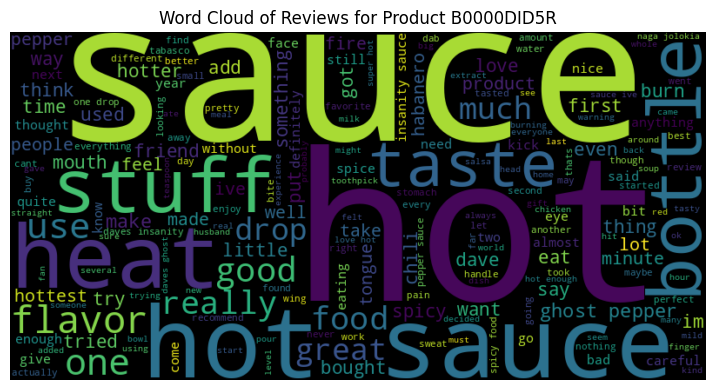

In [ ]:
# Assuming another_column_data contains the reviews text
reviews_text = ' '.join(review_data_1st)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(reviews_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Reviews for Product B0000DID5R')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Filter the rows where 'asin' column equals "B0000DiD5R"
filtered_rows = df[df['asin'] == "616719923X"]
# Show the values of the 'reviews' column from the filtered rows
review_data_2nd = filtered_rows['reviews']

print(review_data_2nd)

51     love green tea anythingit great taste much hur...
52     delicious easily best spin kitkats ever say ta...
53     excellent kitkats get wrong however guess expe...
54     chocolate treat totally different original kit...
55     good got way sooner expected wish flavors avai...
                             ...                        
324    delicious like itby wayi ordering run these hi...
325    purchase seller despite international shipment...
326    great taste love it tried special flavor boyfr...
327    really disappointed taste candy bar felt like ...
328    love green tea traditional kind tastes like gr...
Name: reviews, Length: 278, dtype: object


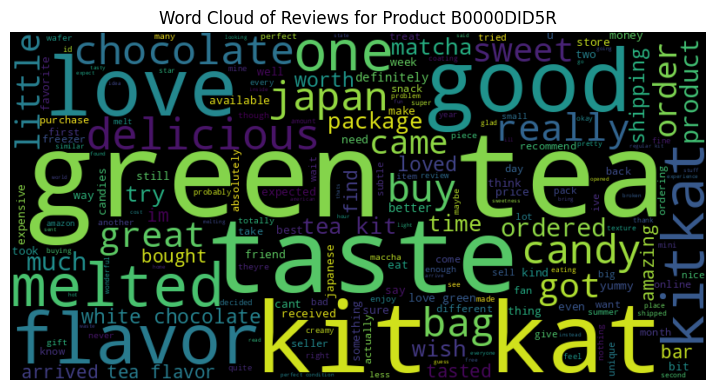

In [ ]:
# Assuming another_column_data contains the reviews text
reviews_text = ' '.join(review_data_2nd)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(reviews_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Reviews for Product B0000DID5R')
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
# Filter the rows where 'asin' column equals "B0000DiD5R"
filtered_rows = df[df['asin'] == "B00006IUTN"]
# Show the values of the 'reviews' column from the filtered rows
review_data_3st = filtered_rows['reviews']

print(review_data_3st)

1283    difficult find stores buy case time great pric...
1284    coffee taste better using filters use brew go ...
1285    filters fit coffee maker could find locally gr...
1286    use quick cup using morning potful great  ther...
1287    much sayit coffee filter works brown ones next...
                              ...                        
1512    black decker cupatatime coffee makerthe perman...
1513    work great one cup coffee maker nice ordering ...
1514    hard find  filter elsewhere dose great job way...
1515    product job well filtering coffee grounds oils...
1516    goes trips   fits perfectly black  decker brew...
Name: reviews, Length: 234, dtype: object


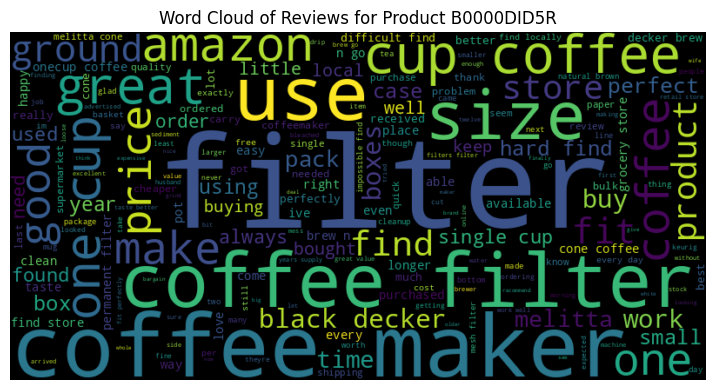

In [ ]:
# Assuming another_column_data contains the reviews text
reviews_text = ' '.join(review_data_3st)

# Generate word cloud
wordcloud = WordCloud(width=800, height=400, background_color='black').generate(reviews_text)

# Display the word cloud using matplotlib
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.title('Word Cloud of Reviews for Product B0000DID5R')
plt.axis('off')
plt.tight_layout()
plt.show()

## Frequency of word

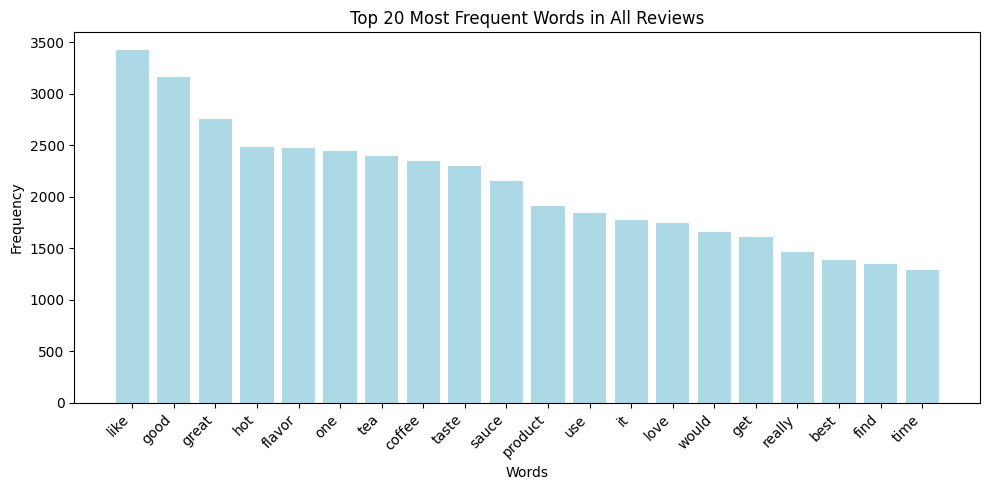

In [ ]:
# Concatenate all reviews into a single text
all_text = ' '.join(df["reviews"])

# Split the text into individual words
all_words = all_text.lower().split()

# Count the frequency of each word
word_freq = Counter(all_words)

# Sort the word frequency dictionary by frequency in descending order
sorted_word_freq = dict(sorted(word_freq.items(), key=lambda x: x[1], reverse=True))

# Extract top N frequent words (e.g., top 20)
top_n = 20
top_words = list(sorted_word_freq.keys())[:top_n]
word_counts = list(sorted_word_freq.values())[:top_n]

# Create a bar chart
plt.figure(figsize=(10, 5))
plt.bar(top_words, word_counts, color='lightblue')
plt.xlabel('Words')
plt.ylabel('Frequency')
plt.title('Top 20 Most Frequent Words in All Reviews')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

## N-gram Analysis

In [ ]:
# Filtering data
review_pos = df[(df["sentiment"] == "Very Positive") | (df["sentiment"] == "Somewhat Positive")].dropna()
review_neu = df[df["sentiment"] == 'Neutral'].dropna()
review_neg = df[(df["sentiment"] == "Very Negative") | (df["sentiment"] == "Somewhat Negative")].dropna()

In [ ]:
# Define custom function for ngram generation
def generate_ngrams(text, n_gram=1):
    token = [token for token in text.lower().split(" ") if token != ""]
    ngrams_list = list(ngrams(token, n_gram))
    return [" ".join(ngram) for ngram in ngrams_list]

# positive reviews for unigrams
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted_pos = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])

# neutral reviews for unigrams
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted_neu = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])

# negative reviews for unigrams
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent):
        freq_dict[word] += 1
fd_sorted_neg = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])

# Bigram section
# positive reviews for bigrams
freq_dict = defaultdict(int)
for sent in review_pos["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted_pos = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])

# neutral reviews for bigrams
freq_dict = defaultdict(int)
for sent in review_neu["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted_neu = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])

# negative reviews for bigrams
freq_dict = defaultdict(int)
for sent in review_neg["reviews"]:
    for word in generate_ngrams(sent, 2):
        freq_dict[word] += 1
fd_sorted_neg = pd.DataFrame(sorted(freq_dict.items(), key=lambda x: x[1], reverse=True)[:25], columns=["word", "wordcount"])

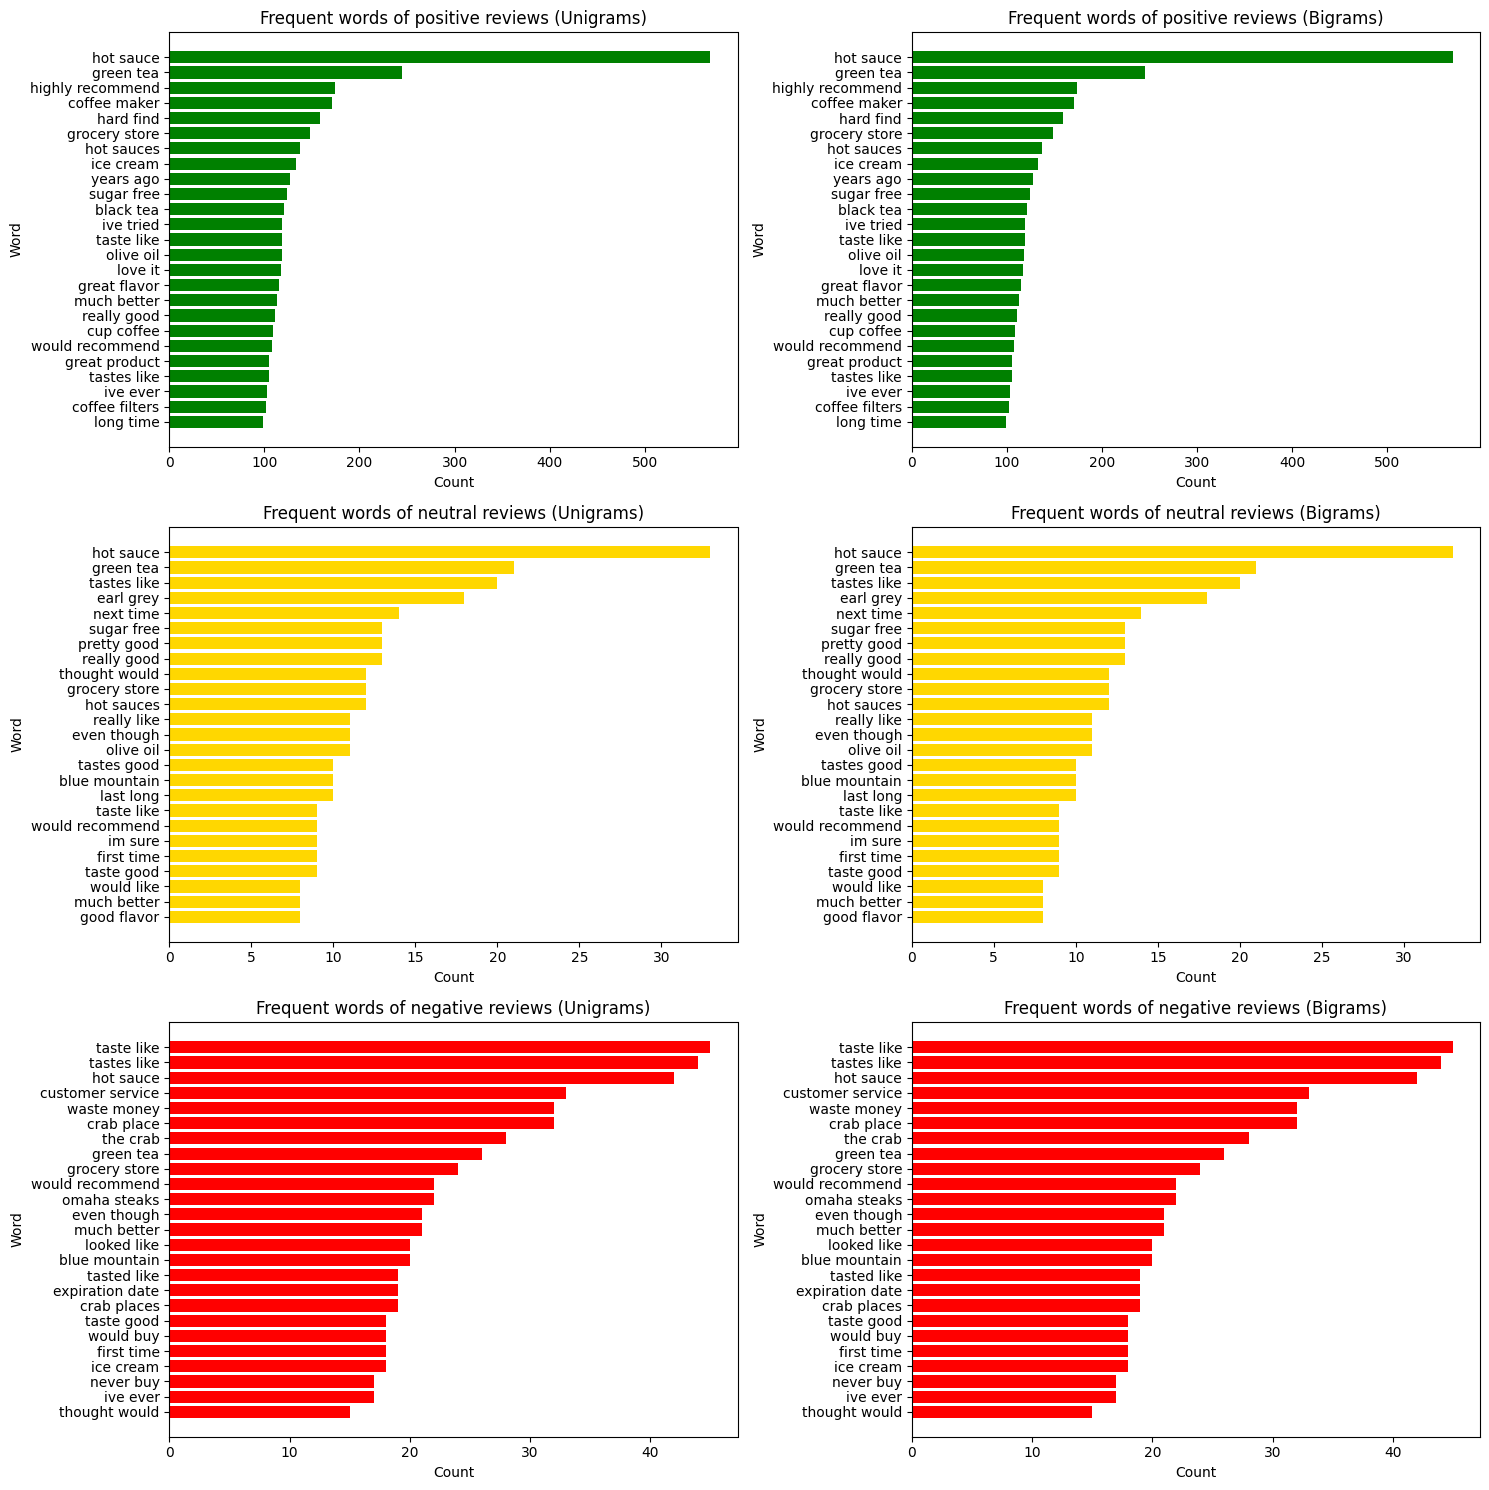

In [ ]:
# Define custom function for generating horizontal bar chart
def horizontal_bar_chart(ax, df, color, title):
    ax.barh(df["word"], df["wordcount"], color=color)
    ax.set_title(title)
    ax.set_xlabel("Count")
    ax.set_ylabel("Word")
    ax.invert_yaxis()

fig, axes = plt.subplots(3, 2, figsize=(15, 15))

# Initialize subplots for unigrams
horizontal_bar_chart(axes[0, 0], fd_sorted_pos, 'green', "Frequent words of positive reviews (Unigrams)")
horizontal_bar_chart(axes[1, 0], fd_sorted_neu, 'gold', "Frequent words of neutral reviews (Unigrams)")
horizontal_bar_chart(axes[2, 0], fd_sorted_neg, 'red', "Frequent words of negative reviews (Unigrams)")

# Initialize subplots for bigrams
horizontal_bar_chart(axes[0, 1], fd_sorted_pos, 'green', "Frequent words of positive reviews (Bigrams)")
horizontal_bar_chart(axes[1, 1], fd_sorted_neu, 'gold', "Frequent words of neutral reviews (Bigrams)")
horizontal_bar_chart(axes[2, 1], fd_sorted_neg, 'red', "Frequent words of negative reviews (Bigrams)")

plt.tight_layout()
plt.show()

## Word Cloud

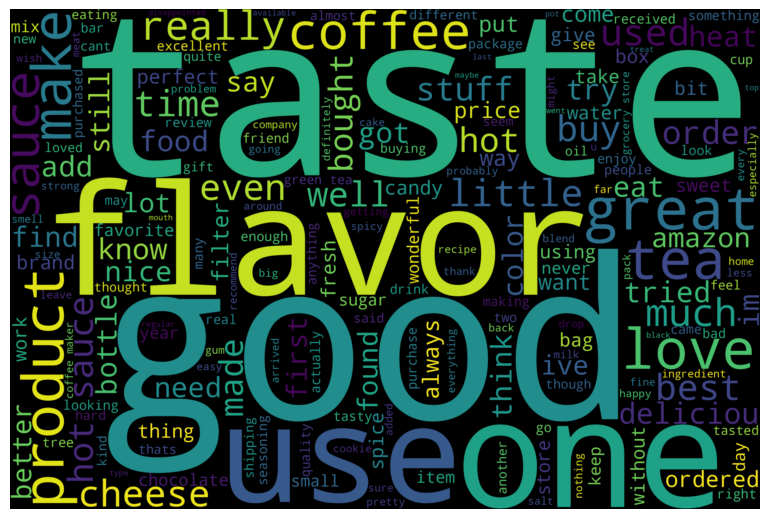

In [ ]:
# Concatenate all reviews into a single text
all_reviews = ' '.join(df["reviews"])

# Generate word cloud
wordcloud = WordCloud(width=3000, height=2000, background_color='black', stopwords=STOPWORDS).generate(all_reviews)

# Display word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

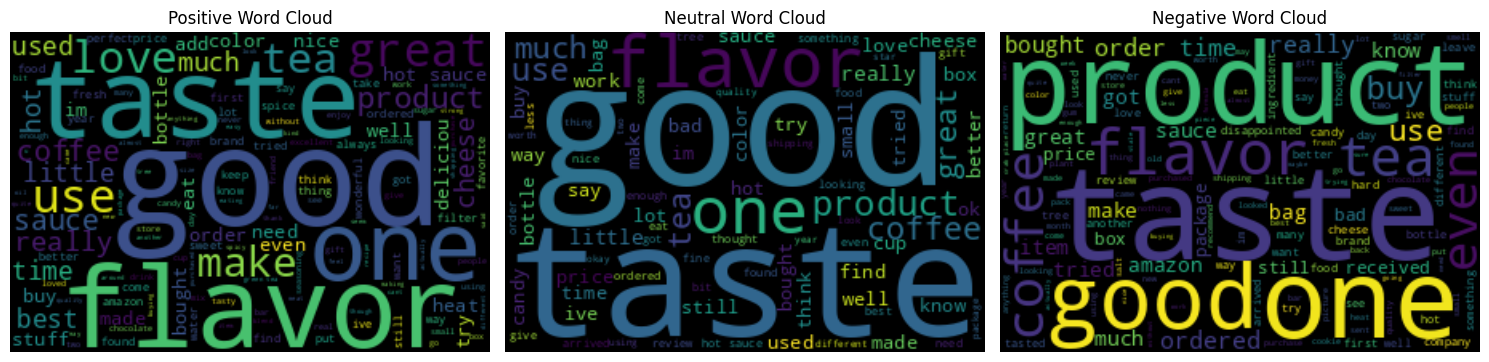

In [ ]:
# Separate reviews based on sentiment
neutral_reviews = df[df["sentiment"] == "Neutral"]["reviews"]
negative_reviews = df[(df["sentiment"] == "Very Negative") | (df["sentiment"] == "Somewhat Negative")]["reviews"]
positive_reviews = df[(df["sentiment"] == "Very Positive") | (df["sentiment"] == "Somewhat Positive")]["reviews"]

# Concatenate all reviews into single texts for each sentiment
all_neutral_reviews = ' '.join(neutral_reviews)
all_negative_reviews = ' '.join(negative_reviews)
all_positive_reviews = ' '.join(positive_reviews)

# Generate word clouds for each sentiment
neutral_wordcloud = WordCloud(width=300, height=200, background_color='black', stopwords=STOPWORDS).generate(all_neutral_reviews)
negative_wordcloud = WordCloud(width=300, height=200, background_color='black', stopwords=STOPWORDS).generate(all_negative_reviews)
positive_wordcloud = WordCloud(width=300, height=200, background_color='black', stopwords=STOPWORDS).generate(all_positive_reviews)

# Plotting
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Positive WordCloud
axes[0].imshow(positive_wordcloud, interpolation='bilinear')
axes[0].set_title('Positive Word Cloud')
axes[0].axis('off')

# Neutral WordCloud
axes[1].imshow(neutral_wordcloud, interpolation='bilinear')
axes[1].set_title('Neutral Word Cloud')
axes[1].axis('off')

# Negative WordCloud
axes[2].imshow(negative_wordcloud, interpolation='bilinear')
axes[2].set_title('Negative Word Cloud')
axes[2].axis('off')

plt.tight_layout()
plt.show()